# proposal 1: using CNN as feature extraction (on 25ms bits of the recordings) (wav2vec2 i guess) which is then passed to the transformer

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # or "tensorflow" or "torch"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import librosa, librosa.display
from pydub import AudioSegment
import soundfile as sf
import keras
# from keras_nlp.layers import
import tensorflow_io as tfio
from keras.utils import audio_dataset_from_directory
# import tensorflow_addons as tfa
from glu_tf import GLU
TRAIN_DIR = './data/train/padded/'
TEST_DIR = './data/test/padded/'
SR = 16000

c:\Users\mipec\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


### data prep

In [88]:
VOCAB_SIZE = len(os.listdir(TRAIN_DIR))
VOCAB_SIZE

30

In [2]:
train_dataset, validation_dataset = audio_dataset_from_directory(directory = TRAIN_DIR,
                                            validation_split = 0.2,
                                            subset = 'both',
                                            seed = 420)

Found 64721 files belonging to 30 classes.
Using 51777 files for training.
Using 12944 files for validation.


In [6]:
for batch, labels in train_dataset.take(1):
    pass

# build a CNN 7 - layer, 512 channels at each layer and a transformer after it

##### positional encoding as in the paper "attention is all you need"
https://www.tensorflow.org/text/tutorials/transformer

In [46]:
model = keras.models.Sequential()
input_width = SR
input_channels = 1
d_model = 512
# Add convolutional layers with GLU activation and layer normalization
model.add(keras.layers.Input((input_width, input_channels)))
model.add(keras.layers.Conv1D(d_model, 10, strides=5, padding='same'))
model.add(keras.layers.LayerNormalization())
model.add(keras.layers.Activation('sigmoid'))
model.add(keras.layers.Conv1D(d_model, 3, strides=2, padding='same'))
model.add(keras.layers.LayerNormalization())
model.add(GLU())
model.add(keras.layers.Conv1D(d_model, 3, strides=2, padding='same'))
model.add(keras.layers.LayerNormalization())
model.add(GLU())
model.add(keras.layers.Conv1D(d_model, 3, strides=2, padding='same'))
model.add(keras.layers.LayerNormalization())
model.add(GLU())
model.add(keras.layers.Conv1D(d_model, 3, strides=2, padding='same'))
model.add(keras.layers.LayerNormalization())
model.add(GLU())
model.add(keras.layers.Conv1D(d_model, 2, strides=2, padding='same'))
model.add(keras.layers.LayerNormalization())
model.add(GLU())
model.add(keras.layers.Conv1D(d_model, 2, strides=2, padding='same'))
model.add(keras.layers.LayerNormalization())
model.add(GLU())
model.summary()
model.compile(loss='mse', optimizer='adam')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)              │ (None, 3200, 512)      │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_16          │ (None, 3200, 512)      │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 3200, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 1600, 512)      │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_17          │ (None, 1600, 512)      │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ glu_13 (GLU)                    │ (None, 1600, 512)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_18 (Conv1D)              │ (None, 800, 512)       │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_18          │ (None, 800, 512)       │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ glu_14 (GLU)                    │ (None, 800, 512)       │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_19 (Conv1D)              │ (None, 400, 512)       │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_19          │ (None, 400, 512)       │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ glu_15 (GLU)                    │ (None, 400, 512)       │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_20 (Conv1D)              │ (None, 200, 512)       │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_20          │ (None, 200, 512)       │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ glu_16 (GLU)                    │ (None, 200, 512)       │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 100, 512)       │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_21          │ (None, 100, 512)       │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ glu_17 (GLU)                    │ (None, 100, 512)       │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 50, 512)        │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_22          │ (None, 50, 512)        │         1,024 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ glu_18 (GLU)                    │ (None, 50, 512)        │         1,024 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 4,216,320 (16.08 MB)

 Trainable params: 4,216,320 (16.08 MB)

 Non-trainable params: 0 (0.00 B)

In [142]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (100**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)


##### custom layer for positional embedding, functions between the attention blocks and the input CNN

In [127]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, d_model):
    super().__init__()
    self.d_model = d_model
    self.pos_encoding = positional_encoding(length=50, depth=d_model)

  def call(self, x):
    batch_size = tf.shape(x)[0]
    length = tf.shape(x)[1]
    # This factor sets the relative scale of the embedding and positional_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    pos_encoding = tf.tile(self.pos_encoding[tf.newaxis, :length, :], [batch_size, 1, 1])
    x = x + pos_encoding
    return x

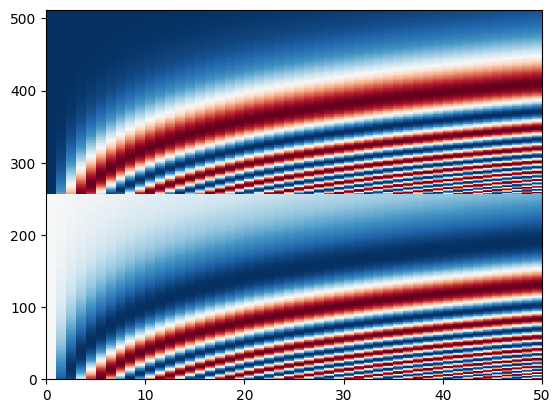

In [143]:
# this is exactly what the positional encoding looks like - this is what we add to every output of the cnn
plt.pcolormesh(positional_encoding(length = 50, depth = 512).numpy().T, cmap='RdBu')

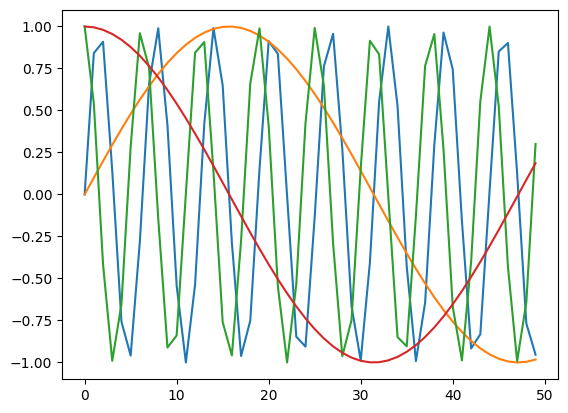

In [145]:
# different frequencies of sinusoid for different dimensions
plt.plot(positional_encoding(length = 50, depth = 512)[:,:512:128])

##### Base Attention class
Functions like a "fuzzy, differentiable, vectorized dictionary lookup"  
In example below, query is 'color', keys are the information held by the dictionary - d, value is 'blue' - result

d = {'color': 'blue', 'age': 22, 'type': 'pickup'}  
result = d['color']

In [146]:
# every Attention mechanism in the transformer 
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [147]:
# The global self attention layer on the other hand lets every sequence element directly access every other sequence element,
# with only a few operations, and all the outputs can be computed in parallel.
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [42]:
# this attends to the generated sequence
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [43]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [44]:
# full encoder layer
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [45]:
# positional embedding and stacked encoder layers

class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [50]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [51]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [52]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [10]:
class GLU(tf.keras.layers.Layer):
    def __init__(self):
        super(GLU, self).__init__()

    def build(self, input_shape):
        # Create trainable weights for scaling and bias parameters
        self.scale = self.add_weight(name='scale',
                                     shape=(input_shape[-1],),
                                     initializer='ones',
                                     trainable=True)
        self.bias = self.add_weight(name='bias',
                                    shape=(input_shape[-1],),
                                    initializer='zeros',
                                    trainable=True)

    def call(self, inputs):
        # Apply the GLU function
        return inputs * tf.sigmoid(inputs * self.scale + self.bias)

In [88]:
out = model.predict(train_dataset.take(1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
for _, label in train_dataset.take(1):
    pass

In [96]:
out_transformer = transformer((out, label))

InvalidArgumentError: Exception encountered when calling PositionalEmbedding.call().

[1m{{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [32,50,512,128] vs. [1,50,128] [Op:AddV2] name: [0m

Arguments received by PositionalEmbedding.call():
  • x=tf.Tensor(shape=(32, 50, 512), dtype=float32)

In [78]:
transformer = Transformer(
    num_layers=4,
    d_model=128,
    num_heads=8,
    dff=64,
    input_vocab_size=50,
    target_vocab_size=2,
    dropout_rate=0.1)

Model: "transformer_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_9 (Encoder)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_3 (Decoder)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define the input dimensions
input_height = 1
input_width = 16000
input_channels = 1

# Define the number of classes for the output layer
num_classes = YOUR_NUM_CLASSES_HERE

# Define the CNN model
model = models.Sequential()

# Add convolutional layers with GLU activation and layer normalization
model.add(layers.Conv1D(512, 10, strides=5, input_shape=(input_width, input_channels), padding='same'))
model.add(layers.LayerNormalization())
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv1D(512, 3, strides=2, padding='same'))
model.add(layers.LayerNormalization())
model.add(GLU())
model.add(layers.Conv1D(512, 3, strides=2, padding='same'))
model.add(layers.LayerNormalization())
model.add(GLU())
model.add(layers.Conv1D(512, 3, strides=2, padding='same'))
model.add(layers.LayerNormalization())
model.add(GLU())
model.add(layers.Conv1D(512, 3, strides=2, padding='same'))
model.add(layers.LayerNormalization())
model.add(GLU())
model.add(layers.Conv1D(512, 2, strides=2, padding='same'))
model.add(layers.LayerNormalization())
model.add(GLU())
model.add(layers.Conv1D(512, 2, strides=2, padding='same'))
model.add(layers.LayerNormalization())
model.add(GLU())


# Transformer layer
num_heads = 8  # Number of attention heads
dff = 2048  # Hidden layer size in feedforward network
transformer_units = [
    dff,
    dff
]  # Size of the transformer layers
transformer_dropout = 0.1  # Dropout rate
transformer = tfa.layers.Transformer(
    num_layers=len(transformer_units),
    units=transformer_units,
    num_heads=num_heads,
    dropout=transformer_dropout
)
model.add(transformer)

# Add a pooling layer or reduce_mean to aggregate the output of the transformer
model.add(layers.GlobalAveragePooling1D())

# Add a dense layer for classification
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()